
# CSC 698
### Parallel Computing


In [1]:
#Importing things needed for calling C functions from python

import scipy
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

## OpenCLR
This class uses ctypes to run functions written in C:

In [2]:
class OpenCLR:
    
    def __init__(self):
        self.model = []
        self.lib = ctypes.cdll.LoadLibrary("./ctest.so")
        self.learn = self.lib.stageForLR
        self.learn.restype = None
        self.learn.argtypes = [ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"), ctypes.c_int,ctypes.c_int,  ndpointer(ctypes.c_float, flags="C_CONTIGUOUS")]
                        
        self.predict = self.lib.stageForPredict
        self.predict.restype = None
        self.predict.argtypes = [ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                               ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"), ctypes.c_int,ctypes.c_int,  ndpointer(ctypes.c_float, flags="C_CONTIGUOUS")]
    
    
    
    #There are two main methods lr_predict and lr_learn
    def lr_learn(self, x, y, model_space):
        self.learn(x, y, 12288, 209, model_space)
        self.model = list(model_space)

    
    def lr_predict(self, x, y, outdata, ysize):
        self.predict(x, np.ascontiguousarray(self.model, np.float32), 12288, ysize, outdata)

# Using OpenCLR

- The following code will use the class that is defined above
- First a model will be generated from labeled immages
- Cat vs Not a Cat
- The model will be used to predict if previously unseen immages are a cat or not

In [3]:

import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import numpy as np


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Loading data
- The following code loads the test and training datasets
- these datasets are vectorized immages
- 64 X 64 X 3 color values

In [4]:

def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    
    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
#Staging data

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
x = train_set_x_flatten
y = train_set_y
xt = test_set_x_flatten
yt = test_set_y
outdata = np.ones(12288 + 1)
dat = np.ascontiguousarray(outdata, np.float32)

### Create the OpenCLR object and Generate a model

In [6]:
Test = OpenCLR()
Test.lr_learn(np.ascontiguousarray(x, np.float32), np.ascontiguousarray(y, np.float32), dat)

### Predict on training data using the model that was just generated

In [7]:
ysize = 209
testdat = np.ones(ysize)
dat = np.ascontiguousarray(testdat, np.float32)
Test.lr_predict(np.ascontiguousarray(x, np.float32), np.ascontiguousarray(y, np.float32), dat, ysize)

In [8]:
y = y[0]
right = 0
for i in range(len(y)):
    if y[i] == dat[i]:
        right = right+ 1

percent = right/len(y)
print("Accuracy on training data " + str(percent*100) + "%")

Accuracy on training data 100.0%


### Predict on previously unseen data using the model

In [9]:
ysize = 50
testdatt = np.ones(ysize)
dat2 = np.ascontiguousarray(testdatt, np.float32)

Test.lr_predict(np.ascontiguousarray(xt, np.float32), np.ascontiguousarray(yt, np.float32), dat2, ysize)

In [10]:
yt = yt[0]
right = 0
wrong = []
correct = []
for i in range(len(yt)):
    if yt[i] == dat2[i]:
        right = right+ 1
        correct.append(i)
    if yt[i] != dat2[i]:
        wrong.append(i)
        
percent = right/len(yt)

print("Accuracy on unseen data " + str(percent*100) + "%")


Accuracy on unseen data 70.0%


### Observe a wrongly predicted image

y = [0], it's a 'non-cat' picture.


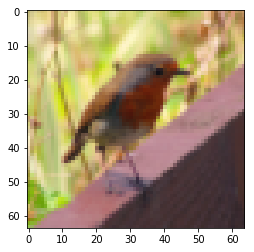

In [11]:

index = wrong[1]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

### Observe a correctly predicted image

y = [1], it's a 'cat' picture.


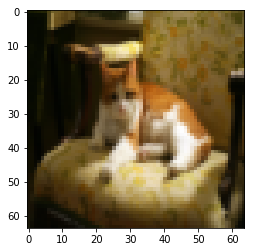

In [18]:
index = correct[6]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")